github: https://github.com/facebook/prophet

api: https://facebook.github.io/prophet/docs/quick_start.html

In [4]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
df = pd.read_csv('../../input/all_data.csv')
df['ds'] = pd.to_datetime(df['TIME'])
#df.index = pd.DatetimeIndex(df['ds'],name='index')
df['y'] = df['zhexi_in']
df = df.dropna()
df.head(5)
# train_df = df[df['ds'] < '2018/1/1 0:00:00']
# test_df = df[df['ds'] >= '2018/1/1 0:00:00']

,TIME,zhexi_in,xiaoxi_out,lengshuijiang_add,xinhua_add,zhexi_add,ds,y
0,2015/1/1 0:00,180.475,67.0,0,0,0,2015-01-01 00:00:00,180.475
1,2015/1/1 1:00,206.634,65.0,0,0,0,2015-01-01 01:00:00,206.634
2,2015/1/1 2:00,200.758,66.0,0,0,0,2015-01-01 02:00:00,200.758
3,2015/1/1 3:00,183.565,66.0,0,0,0,2015-01-01 03:00:00,183.565
4,2015/1/1 4:00,167.910,66.0,0,0,0,2015-01-01 04:00:00,167.910


In [6]:
len(df)

28501

In [7]:
def rolling_predict(data,start,train_period,test_period,pdf,other_params):
    train = data[start:start+train_period]
    test = data[start+train_period:start+train_period+test_period]
    train.index = [i for i in range(train_period)]
    test.index = [i for i in range(train_period,train_period+test_period)]
    m = Prophet(daily_seasonality=other_params['daily_seasonality'],
                weekly_seasonality=other_params['weekly_seasonality'],
                yearly_seasonality=other_params['yearly_seasonality'])
    m.fit(train[['ds','y']])
    future = m.make_future_dataframe(periods=test_period,freq='h')
    forecast = m.predict(future)
    #m.plot(forecast)
    
    forecast['yhat'].plot()
    # forecast['yhat_upper'].plot()
    # forecast['yhat_lower'].plot()
    train['y'].plot()
    test['y'].plot()
    mse = mean_squared_error(test['y'],forecast['yhat'][-test_period:])
    plt.title(f"{other_params['type']}: {other_params[other_params['type']]}  mse: {mse}")
    plt.legend(('yhat','train','test'))
    x = [i for i in range(train_period,train_period+test_period)]
    plt.fill_between(x,np.array(forecast['yhat_upper'][train_period:]),np.array(forecast['yhat_lower'][train_period:])
                    ,color='blue',alpha=0.25)
    #plt.show()
    pdf.savefig()                            #将图片保存在pdf文件中
    plt.close()

def days_pre(days):
    for day in days:
        pdf = PdfPages(f'../output/plot/2015_{day}days_pre.pdf')
        for start in range(0,24*365+1,day*24):
            rolling_predict(df,start,(day-1)*24,24,pdf,{'type':f'{day}days',f'{day}days':int(start/ (day*24) + 1),
                                             'daily_seasonality':True,'weekly_seasonality':'auto','yearly_seasonality':False})
        pdf.close()
def weeks_pre(weeks):
    for week in weeks:
        pdf = PdfPages(f'../output/plot/2015_{week}weeks_pre.pdf')
        for start in range(0,24*7*52+1,week*7*24):
            rolling_predict(df,start,(week*7-1)*24,24,pdf,{'type':f'{week}weeks',f'{week}weeks':int(start/ (week*7*24) + 1),
                                             'daily_seasonality':True,'weekly_seasonality':'auto','yearly_seasonality':False})
        pdf.close()

In [8]:
# days_pre([i for i in range(2,3)])
# weeks_pre([i for i in range(4,5)])

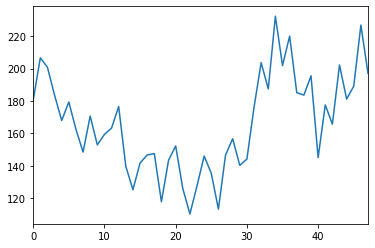

In [9]:
df['y'][:48].plot()

In [10]:
def get_ndays_points_before_current_points(data,cur,n):
    return data[cur-n*24:cur]

def get_current_day_points(data,cur):
    return data[cur:cur+24]

def current_day_predict(data):
    m = Prophet(daily_seasonality=True,weekly_seasonality='auto',yearly_seasonality='auto')
    m.fit(data[['ds','y']])
    future = m.make_future_dataframe(periods=24,freq='h')
    forecast = m.predict(future)
    return forecast
def plot_result(forecast,train,test,title,n,pdf=None):
    predict = forecast['yhat']
#     print(len(predict))
#     predict_upper = forecast['yhat_upper']
#     predict_lower = forecast['yhat_lower']
    predict.index = [i for i in range((n+1)*24)]
    predict.plot()
#     predict_upper.index = [i for i in range((n+1)*24)]
#     predict_lower.index = [i for i in range((n+1)*24)]
    train.index = [i for i in range(n*24)]
    test.index = [i for i in range(n*24,(n+1)*24)]
#     forecast['yhat_upper'].plot()
#     forecast['yhat_lower'].plot()
    train['y'].plot()
    test['y'].plot()
    mse = mean_squared_error(test['y'],predict[-24:])
    plt.title(f"{title}  mse: {mse}")
    plt.legend(('yhat','train','test'))
    x = [i for i in range(n*24,(n+1)*24)]
    plt.fill_between(x,np.array(forecast['yhat_upper'][n*24:]),np.array(forecast['yhat_lower'][n*24:])
                    ,color='blue',alpha=0.25)
    #plt.show()
    pdf.savefig()                            #将图片保存在pdf文件中
    plt.close()
    
def cur_day_predict_by_former_Ndays(data,N,cur):
    results = pd.DataFrame()
    test = get_current_day_points(df,cur)
    results['real_value'] = pd.Series(test['y'])
    pdf = PdfPages(f'../output/plot/cur_point_pre/{str((N[0],N[-1]))}_{data.ix[cur,"ds"]}.pdf')
    for n in N:
        print(f'former {n} days')
        train = get_ndays_points_before_current_points(df,cur,n)
        forecast = current_day_predict(train)
        plot_result(forecast,train,test,f'{n}day(s)',n,pdf)
#         print(np.array(forecast['yhat'][n*24:(n+1)*24]))
        results[f'{n}_days_based_pre'] =np.array(forecast['yhat'][n*24:(n+1)*24])
    pdf.close()
    plt.close()
    return results

In [14]:
#pick a data point:CUR_POINT, then choose the farest data period the modle can see, in this choose 12 days
CUR_POINT = 5000
DAYS = 12
retults = cur_day_predict_by_former_Ndays(df,[i for i in range(1,DAYS+1)],CUR_POINT)

/home/harrison/anaconda3/envs/prophet/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 18.


former 1 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 2 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 3 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 4 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 5 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 6 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 7 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 8 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 9 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 10 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 11 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 12 days


In [11]:
retults

,real_value,1_days_based_pre,2_days_based_pre,3_days_based_pre,4_days_based_pre,5_days_based_pre,6_days_based_pre,7_days_based_pre,8_days_based_pre,9_days_based_pre,10_days_based_pre,11_days_based_pre,12_days_based_pre
4000,1019.103,1103.096840,1158.775966,1334.223581,1282.075908,1294.347436,1174.468185,1073.920963,849.017174,716.965406,656.143187,723.125097,817.421464
4001,1023.131,1133.937247,1177.960607,1370.849728,1300.661988,1298.357957,1171.960517,1109.346879,814.316548,669.051033,658.893837,736.025559,835.939675
4002,1107.425,1135.033985,1138.109580,1348.428223,1272.777619,1299.041157,1153.769528,1139.491350,818.576453,653.278700,652.613472,729.138843,836.383175
4003,1148.869,1105.478124,1055.480330,1284.629107,1214.371282,1297.400915,1127.786066,1159.725678,856.772409,669.397965,643.692933,710.460538,825.311453
4004,1107.706,1064.743985,972.789314,1219.489952,1158.186844,1298.398894,1106.524984,1174.611427,908.999274,702.594118,643.054720,697.272975,818.271861
4005,1107.174,1037.375860,930.104722,1188.629187,1132.262202,1311.322654,1101.835078,1195.135134,961.092853,741.663117,660.914552,705.260001,829.341506
4006,1101.559,1037.148553,941.704206,1203.096070,1144.836283,1345.867225,1120.642724,1231.345286,1015.883378,789.717183,701.786183,739.564205,862.694447
4007,1123.688,1061.676562,993.818574,1248.554220,1184.918603,1405.199530,1162.855328,1285.310769,1084.731710,856.730725,761.746144,793.126695,911.501493
4008,1050.491,1097.917013,1059.742314,1300.078257,1234.137263,1481.093437,1221.287061,1349.002589,1169.091085,942.318025,829.015943,851.707487,963.218049
4009,1021.156,1130.785849,1116.768585,1338.298675,1277.974749,1555.868919,1283.319635,1408.045628,1251.591095,1027.339721,887.704529,900.719737,1005.965855


array([6.55658680e-01, 3.06260386e-01, 3.50476359e-02, 1.36680332e-03,
       2.97668580e-05, 2.78512685e-04, 7.03222462e-04, 2.78512685e-04,
       2.97668580e-05, 6.03706108e-05, 8.09147093e-05, 6.03706108e-05,
       2.97668580e-05, 3.72258133e-05, 4.08384237e-05, 3.72258133e-05])

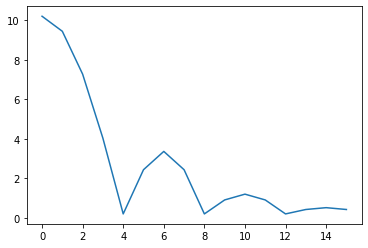

In [12]:
def lower_pass_filter(n,period,amplitude,shift):
    res = []
    for i in range(int(n / period)+1):
        weight_decay = (1 / (10 ** 0.5)) ** i
        if i == 0:
            res.append(shift + weight_decay *amplitude * np.cos([i*(np.pi/2)/period for i in range(period)] ))
        else:
            res.append(shift + weight_decay *amplitude * np.cos([-np.pi/2 + i*(np.pi)/period for i in range(period)] ))
    return res
res = np.array(lower_pass_filter(12,4,10,0.2)).reshape(-1)
plt.plot(res)
denominator = np.sum(np.exp(res))
numerator = np.exp(res)
res = numerator / denominator
res

In [14]:
retults[retults.columns[:DAYS+1]]

,real_value,1_days_based_pre,2_days_based_pre,3_days_based_pre,4_days_based_pre,5_days_based_pre,6_days_based_pre,7_days_based_pre,8_days_based_pre,9_days_based_pre,10_days_based_pre,11_days_based_pre,12_days_based_pre
4000,1019.103,1103.096840,1158.775966,1334.223581,1282.075908,1294.347436,1174.468185,1073.920963,849.017174,716.965406,656.143187,723.125097,817.421464
4001,1023.131,1133.937247,1177.960607,1370.849728,1300.661988,1298.357957,1171.960517,1109.346879,814.316548,669.051033,658.893837,736.025559,835.939675
4002,1107.425,1135.033985,1138.109580,1348.428223,1272.777619,1299.041157,1153.769528,1139.491350,818.576453,653.278700,652.613472,729.138843,836.383175
4003,1148.869,1105.478124,1055.480330,1284.629107,1214.371282,1297.400915,1127.786066,1159.725678,856.772409,669.397965,643.692933,710.460538,825.311453
4004,1107.706,1064.743985,972.789314,1219.489952,1158.186844,1298.398894,1106.524984,1174.611427,908.999274,702.594118,643.054720,697.272975,818.271861
4005,1107.174,1037.375860,930.104722,1188.629187,1132.262202,1311.322654,1101.835078,1195.135134,961.092853,741.663117,660.914552,705.260001,829.341506
4006,1101.559,1037.148553,941.704206,1203.096070,1144.836283,1345.867225,1120.642724,1231.345286,1015.883378,789.717183,701.786183,739.564205,862.694447
4007,1123.688,1061.676562,993.818574,1248.554220,1184.918603,1405.199530,1162.855328,1285.310769,1084.731710,856.730725,761.746144,793.126695,911.501493
4008,1050.491,1097.917013,1059.742314,1300.078257,1234.137263,1481.093437,1221.287061,1349.002589,1169.091085,942.318025,829.015943,851.707487,963.218049
4009,1021.156,1130.785849,1116.768585,1338.298675,1277.974749,1555.868919,1283.319635,1408.045628,1251.591095,1027.339721,887.704529,900.719737,1005.965855


In [15]:
def step_mean_pre_show(results,n,cur,weight_type='same'):
    row,col = int(n/3)+1,3
    plt.figure(figsize=(16,row*4))
    for i in range(1,n+1):
        plt.subplot(row,col,i)
        weights = get_weights(i,weight_type,results=results)
        print(weights)
        results[f'mean_pre_{i}'] = np.dot(np.array(results[results.columns[1:i+1]]),weights)
        plt.plot(results['real_value'])
        plt.plot(results[f'mean_pre_{i}'])
        plt.title(f"{i} mean predict, mse {mean_squared_error(results[f'mean_pre_{i}'],results['real_value'])}")
        plt.legend(('real_value','predict'))
#     plt.suptitle(f'{cur}_{n}',fontsize=18)
    plt.savefig(f'../output/plot/cur_point_pre/{cur}_{n}.png',dpi=120)
    plt.show()

lower_pass_filter_value = np.array(lower_pass_filter(DAYS,4,10,0.2)).reshape(-1)
upper_pass_filter_value = []
for i in range(DAYS):
    upper_pass_filter_value.append(lower_pass_filter_value[DAYS-i-1])
print(upper_pass_filter_value)

def get_weights(n,weight_type='same',results=None):
    if weight_type is 'same':
        return np.array(n*[1.0/n])
    elif weight_type is 'softmax_naive':
        denominator = np.sum(np.exp([i for i in range(n)]))
#         print(denominator)
        numerator = np.exp(np.abs(np.sort([-i for i in range(n)])))
#         print(numerator)
        return numerator / denominator
    elif weight_type is 'softmax_cos_lower_pass':
        res = lower_pass_filter_value[:n]
#         print(res)
        denominator = np.sum(np.exp(res))
        numerator = np.exp(res)
        return numerator / denominator
#     elif weight_type is 'softmax_distance':
#         distances = []
#         for i in range(1,DAYS+1):
#             mse = np.sqrt(mean_squared_error(results[results.columns[0]],results[results.columns[i]]))
#             print(mse)
#             distances.append(mse)
#         distances = np.array(distances).reshape(-1)
#         numerator = np.exp(distances/1000)
#         denominator = np.sum(np.exp(1/distances))
#         return numerator / denominator
    else:
        pass
                  
def lower_pass_filter(n,period,amplitude,shift):
    res = []
    for i in range(int(n / period)+1):
        weight_decay = (1 / (10 ** 0.5)) ** i
        if i == 0:
            res.append(shift + weight_decay *amplitude * np.cos([i*(np.pi/2)/period for i in range(period)] ))
        else:
            res.append(shift + weight_decay *amplitude * np.cos([-np.pi/2 + i*(np.pi)/period for i in range(period)] ))
    return res
print('same weight\n',get_weights(12,'same'),'\n')
print('softmax naive\n',get_weights(12,'softmax_naive'),'\n')
print('softmax_cos_lower_pass\n',get_weights(12,'softmax_cos_lower_pass'))

[0.9071067811865476, 1.2, 0.9071067811865476, 0.20000000000000007, 2.43606797749979, 3.3622776601683797, 2.43606797749979, 0.2000000000000002, 4.026834323650898, 7.271067811865476, 9.438795325112867, 10.2]
same weight
 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333] 

softmax naive
 [6.32124443e-01 2.32545587e-01 8.55487405e-02 3.14716228e-02
 1.15777630e-02 4.25922099e-03 1.56687984e-03 5.76422879e-04
 2.12054127e-04 7.80103536e-05 2.86984053e-05 1.05575533e-05] 

softmax_cos_lower_pass
 [6.55753802e-01 3.06304818e-01 3.50527205e-02 1.36700162e-03
 2.97711766e-05 2.78553091e-04 7.03324484e-04 2.78553091e-04
 2.97711766e-05 6.03793692e-05 8.09264482e-05 6.03793692e-05]


In [16]:
# def lower_pass_filter(n,period,amplitude,shift):
#     res = []
#     for i in range(int(n / period)+1):
#         weight_decay = (1 / (10 ** 0.5)) ** i
#         if i == 0:
#             res.append(shift + weight_decay *amplitude * np.cos([i*(np.pi/2)/period for i in [np.linspace(0,period,100)]] ))
#         else:
#             res.append(shift + weight_decay *amplitude * np.cos([-np.pi/2 + i*(np.pi)/period for i in [np.linspace(0,period,100)]] ))
#     return res
# res = np.array(lower_pass_filter(12,4,1,0.2)).reshape(-1)
# denominator = np.sum(np.exp(res))
# numerator = np.exp(res)
# res = numerator / denominator
# res
# plt.plot(np.linspace(0,12,400),res)

[1.]
[0.68161522 0.31838478]
[0.65765354 0.30719219 0.03515427]
[0.65675316 0.30677162 0.03510614 0.00136908]
[6.56733574e-01 3.06762473e-01 3.51050934e-02 1.36904408e-03
 2.98156582e-05]
[6.56550417e-01 3.06676919e-01 3.50953028e-02 1.36866226e-03
 2.98073428e-05 2.78891480e-04]
[6.56088413e-01 3.06461116e-01 3.50706069e-02 1.36769916e-03
 2.97863679e-05 2.78695228e-04 7.03683369e-04]
[6.55905616e-01 3.06375730e-01 3.50608356e-02 1.36731809e-03
 2.97780689e-05 2.78617579e-04 7.03487311e-04 2.78617579e-04]
[6.55886085e-01 3.06366607e-01 3.50597916e-02 1.36727738e-03
 2.97771822e-05 2.78609282e-04 7.03466363e-04 2.78609282e-04
 2.97771822e-05]
[6.55846477e-01 3.06348106e-01 3.50576744e-02 1.36719481e-03
 2.97753840e-05 2.78592458e-04 7.03423882e-04 2.78592458e-04
 2.97753840e-05 6.03879024e-05]
[6.55793398e-01 3.06323313e-01 3.50548371e-02 1.36708416e-03
 2.97729742e-05 2.78569911e-04 7.03366953e-04 2.78569911e-04
 2.97729742e-05 6.03830151e-05 8.09313348e-05]
[6.55753802e-01 3.06304818

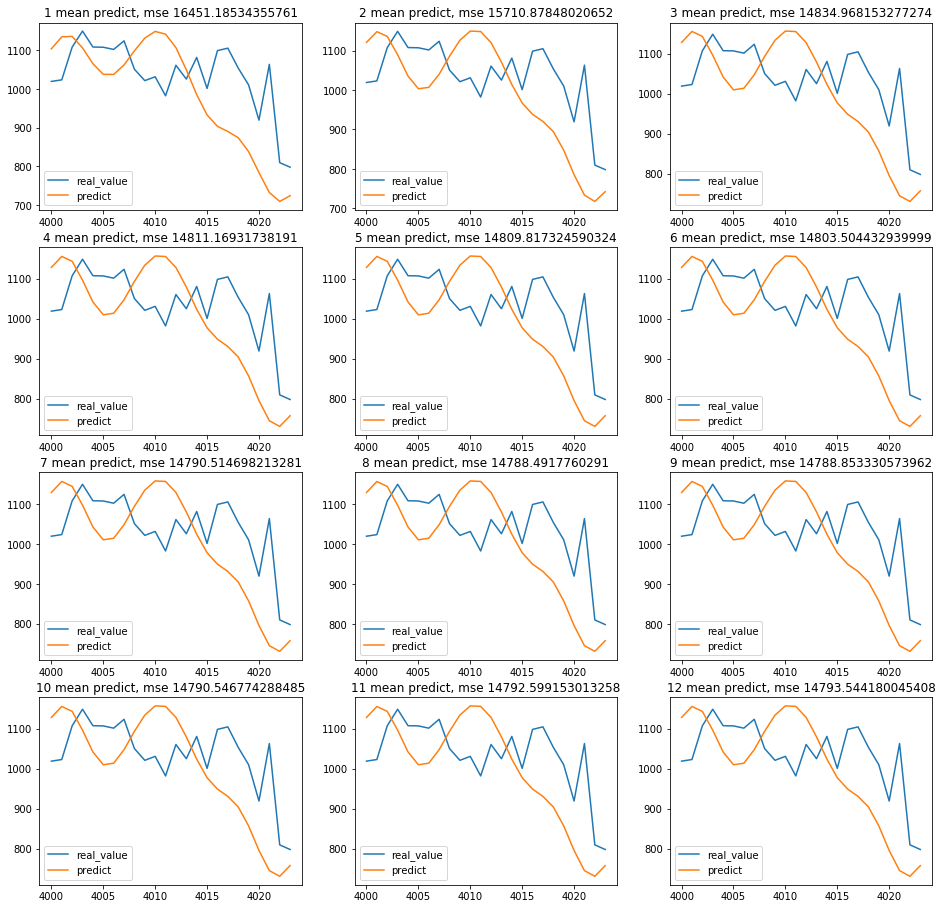

In [17]:
step_mean_pre_show(retults,DAYS,CUR_POINT,'softmax_cos_lower_pass')

/home/harrison/anaconda3/envs/prophet/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 18.


former 1 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 2 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 3 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 4 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 5 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 6 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 7 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 8 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 9 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 10 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 11 days


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


former 12 days
[1.]
[0.68161522 0.31838478]
[0.65765354 0.30719219 0.03515427]
[0.65675316 0.30677162 0.03510614 0.00136908]
[6.56733574e-01 3.06762473e-01 3.51050934e-02 1.36904408e-03
 2.98156582e-05]
[6.56550417e-01 3.06676919e-01 3.50953028e-02 1.36866226e-03
 2.98073428e-05 2.78891480e-04]
[6.56088413e-01 3.06461116e-01 3.50706069e-02 1.36769916e-03
 2.97863679e-05 2.78695228e-04 7.03683369e-04]
[6.55905616e-01 3.06375730e-01 3.50608356e-02 1.36731809e-03
 2.97780689e-05 2.78617579e-04 7.03487311e-04 2.78617579e-04]
[6.55886085e-01 3.06366607e-01 3.50597916e-02 1.36727738e-03
 2.97771822e-05 2.78609282e-04 7.03466363e-04 2.78609282e-04
 2.97771822e-05]
[6.55846477e-01 3.06348106e-01 3.50576744e-02 1.36719481e-03
 2.97753840e-05 2.78592458e-04 7.03423882e-04 2.78592458e-04
 2.97753840e-05 6.03879024e-05]
[6.55793398e-01 3.06323313e-01 3.50548371e-02 1.36708416e-03
 2.97729742e-05 2.78569911e-04 7.03366953e-04 2.78569911e-04
 2.97729742e-05 6.03830151e-05 8.09313348e-05]
[6.55753802

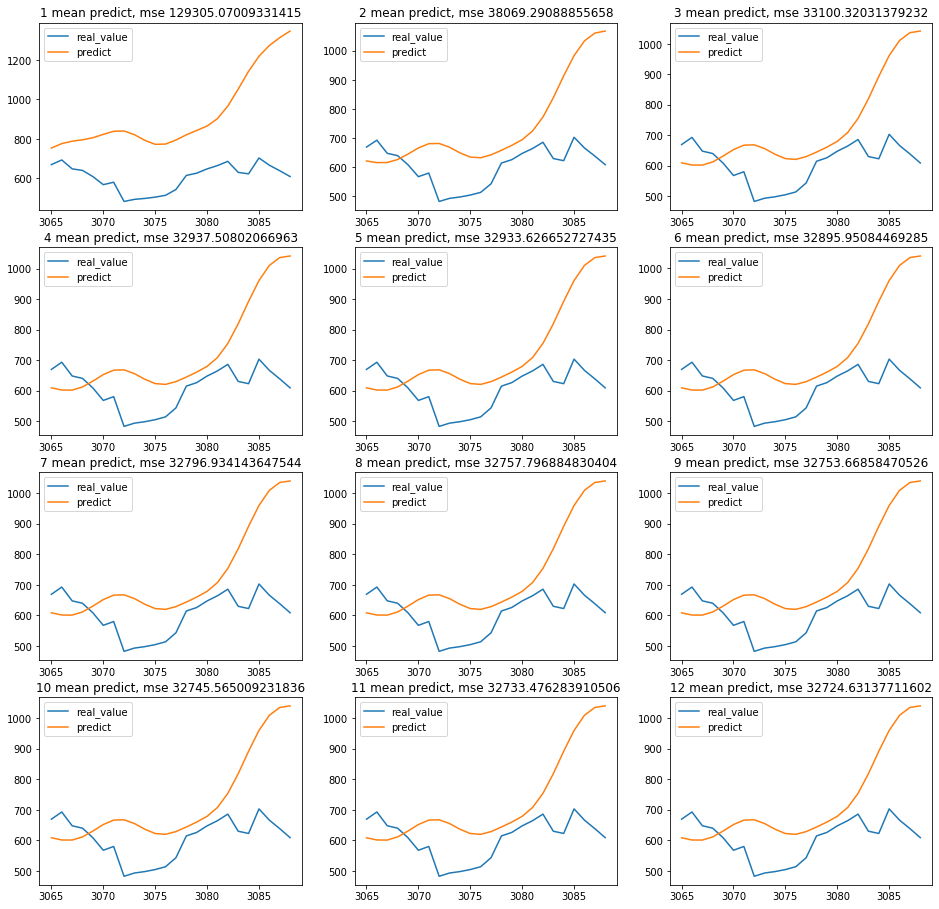

In [15]:
for cur in np.random.randint(2400,4800,1,'int'):
    
    retults = cur_day_predict_by_former_Ndays(df,[i for i in range(1,DAYS+1)],cur)
    step_mean_pre_show(retults,DAYS,f'{cur}_{DAYS}','softmax_cos_lower_pass')

In [45]:
df[CUR_POINT:CUR_POINT + 1]

,TIME,zhexi_in,xiaoxi_out,lengshuijiang_add,xinhua_add,zhexi_add,ds,y
8000,2015/11/30 8:00,714.887,599.0,0,0,0,2015-11-30 08:00:00,714.887


# the end

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from IPython.display import SVG
print(tf.__version__)

2.0.0-beta0


In [29]:
ts = pd.DataFrame()
ts['current'] = df['zhexi_in']

In [30]:
def make_former_Npoints_time_series(df,N):
    for i in range(1,N+1):
        df[f'current_before_{i}'] = df['current'].shift(i)
    return df.dropna()
# make_former_Npoints_time_series(ts,12 * 24)

def make_next_Mpoints_time_series(df,M):
    for i in range(1,M):
        df[f'current_next_{i}'] = df['current'].shift(-i)
    return df.dropna()
# make_next_Mpoints_time_series(ts,1*24)

In [31]:
M = 1 * 24
N = 12 * 24
ts = make_next_Mpoints_time_series(ts,M)
ts = make_former_Npoints_time_series(ts,N)

In [37]:
ts.shape

(28190, 312)

In [ ]:
from 

In [39]:
x_train = ts[:20000][ts.columns[M:]]
y_train = ts[:20000][ts.columns[:M]]
x_test = ts[20000:][ts.columns[M:]]
y_test = ts[20000:][ts.columns[:M]]

In [40]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((20000, 288), (20000, 24), (8190, 288), (8190, 24))

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 288)]             0         
_________________________________________________________________
code (Dense)                 (None, 24)                6936      
_________________________________________________________________
outputs (Dense)              (None, 288)               7200      
Total params: 14,136
Trainable params: 14,136
Non-trainable params: 0
_________________________________________________________________


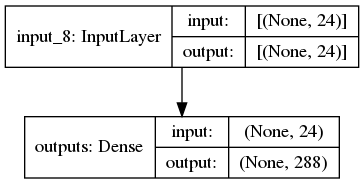

In [107]:
code_dim = M
inputs = layers.Input(shape=(x_train.shape[1],), name='inputs')
code = layers.Dense(code_dim, activation='relu', name='code')(inputs)
outputs = layers.Dense(x_train.shape[1], activation='relu', name='outputs')(code)

auto_encoder = keras.Model(inputs, outputs)
auto_encoder.summary()

encoder = keras.Model(inputs,code)
keras.utils.plot_model(encoder, show_shapes=True)

decoder_input = keras.Input((code_dim,))
decoder_output = auto_encoder.layers[-1](decoder_input)
decoder = keras.Model(decoder_input, decoder_output)
keras.utils.plot_model(decoder, show_shapes=True)

In [108]:
auto_encoder.compile(optimizer='adam',
                    loss=tf.losses.mean_squared_error)

In [109]:
history = auto_encoder.fit(x_train, x_train, batch_size=64, epochs=100, validation_split=0.1)

Train on 18000 samples, validate on 2000 samples
Epoch 1/100
18000/18000 [==============================] - 1s 39us/sample - loss: 446134.6722 - val_loss: 63117.3544
Epoch 2/100
18000/18000 [==============================] - 1s 32us/sample - loss: 199991.7533 - val_loss: 48580.1216
Epoch 3/100
18000/18000 [==============================] - 1s 32us/sample - loss: 164359.2797 - val_loss: 44673.2396
Epoch 4/100
18000/18000 [==============================] - 1s 32us/sample - loss: 146682.1912 - val_loss: 42669.6407
Epoch 5/100
18000/18000 [==============================] - 1s 32us/sample - loss: 137682.3613 - val_loss: 42009.6193
Epoch 6/100
18000/18000 [==============================] - 1s 32us/sample - loss: 131582.3851 - val_loss: 42130.5231
Epoch 7/100
18000/18000 [==============================] - 1s 32us/sample - loss: 127165.8135 - val_loss: 41198.6394
Epoch 8/100
18000/18000 [==============================] - 1s 32us/sample - loss: 123352.5175 - val_loss: 41306.8354
Epoch 9/100
180

In [110]:
encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)

In [111]:
y_hat = auto_encoder.predict(x_test)

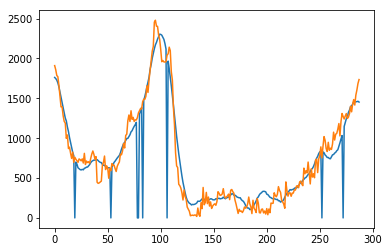

In [113]:
temp = 1000
plt.plot(y_hat[temp])
plt.plot(np.array(x_test[temp:temp+1]).reshape(-1))

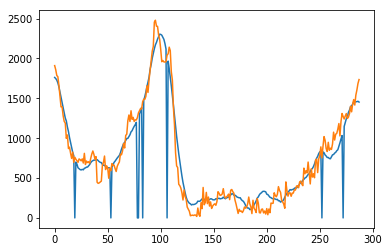

In [116]:
plt.plot(decoded[temp])
plt.plot(np.array(x_test[temp:temp+1]).reshape(-1))